# HPC Mini-Challenge 2 - Beschleunigung in Data Science
## Teil 2: GPU
#### FHNW - FS22

Original von S. Suter, angepasst für das HS22 von S. Marcin

Abgabe von: <font color='blue'>Haris Alic</font>

#### Ressourcen
* [Überblick GPU Programmierung](https://www.cherryservers.com/blog/introduction-to-gpu-programming-with-cuda-and-python)
* [CUDA Basic Parts](https://nyu-cds.github.io/python-gpu/02-cuda/)
* [Accelerate Code with CuPy](https://towardsdatascience.com/heres-how-to-use-cupy-to-make-numpy-700x-faster-4b920dda1f56)
* Vorlesungen und Beispiele aus dem Informatikkurs PAC (parallel computing), siehe resourcen
* CSCS "High-Performance Computing with Python" Kurs, Tag 3: 
    - JIT Numba GPU 1 + 2
    - https://youtu.be/E4REVbCVxNQ
    - https://github.com/eth-cscs/PythonHPC/tree/master/numba-cuda
    - Siehe auch aktuelles Tutorial von 2021
* [Google CoLab](https://colab.research.google.com/) oder ggf. eigene GPU.


In [ ]:
#!pip install numba

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Dummy Beispiel zum testen mit Numba

import math
from numba import vectorize
import numpy as np

@vectorize(['float32(float32)'], target='cuda')
def gpu_sqrt(x):
    return math.sqrt(x)
  

a = np.arange(4096,dtype=np.float32)
gpu_sqrt(a)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 4 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


array([ 0.       ,  1.       ,  1.4142135, ..., 63.97656  , 63.98437  ,
       63.992188 ], dtype=float32)

### 5 GPU Rekonstruktion

Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting. Code aus dem ersten Teil darf dabei verwendet werden. Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind. Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein. Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden. Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst. Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

Links:
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)

In [ ]:
import numpy as np
from numba import cuda
import time

@cuda.jit
def reconstruct_svd(U, s, Vt, A):
    row, col = cuda.grid(2)
    if row < U.shape[0] and col < Vt.shape[1]:
        value = 0
        for i in range(s.shape[0]):
            value += s[i] * U[row, i] * Vt[i, col]
        A[row, col] = value

# Create the matrices on the host
generator = np.random.default_rng()
N = 1024
A = generator.random((N, N))
U, s, Vt = np.linalg.svd(A, full_matrices=True)
print("A shape: {}, U shape: {}, s shape: {}, Vt shape: {}".format(
    A.shape, U.shape, s.shape, Vt.shape
))

# Allocate memory on GPU
U_device = cuda.to_device(U)
s_device = cuda.to_device(s)
Vt_device = cuda.to_device(Vt)
A_device = cuda.device_array_like(A)
print("Transfered matrices to the GPU")

# Invoking a cuda kernel
block_size = (32, 32)
num_blocks_x = N // block_size[0]
if N % num_blocks_x:
  num_blocks_x += 1
num_blocks_y = N // block_size[1]
if N % num_blocks_x:
  num_blocks_x += 1
num_blocks = (num_blocks_x, num_blocks_y)
print("block_size: {}, num_blocks: {}".format(
    block_size, num_blocks
))

# Run the kernel
start = time.time()
reconstruct_svd[num_blocks, block_size](U_device, s_device, Vt_device, A_device)
end = time.time()

# Transfer result back to CPU
A = A_device.copy_to_host()
print("Transfered result back to CPU")

assert np.allclose(U @ np.diag(s) @ Vt, A)

print("Time: {}".format(end-start))

A shape: (1024, 1024), U shape: (1024, 1024), s shape: (1024,), Vt shape: (1024, 1024)
Transfered matrices to the GPU
block_size: (32, 32), num_blocks: (32, 32)
Transfered result back to CPU
Time: 0.20265650749206543


Implementiere eine SVD-Rekonstruktionsvariante auf der GPU oder in einem hybriden Setting.  
Code aus dem ersten Teil darf dabei verwendet werden.  
Wähle  bewusst, welche Teile des Algorithms in einem GPU Kernel implementiert werden und welche effizienter auf der CPU sind.  
Ziehe dafür Erkenntnisse aus dem ersten Teil mit ein  
Es muss mindestens eine Komponente des Algorithmuses in einem GPU-Kernel implementiert werden.  
Dokumentiere Annahmen, welche du ggf. zur Vereinfachung triffst.  
Evaluiere, ob du mit CuPy oder Numba arbeiten möchtest.

<font color='blue'>Wir erstellen eine Matrix N x N und führen die SVD auf der CPU aus. Der Output sind die Matrizen U, s, Vt welche wir für die Rekonstruktion nutzen. Die Matrizen U, s und Vt senden wir vom Host zum Device (GPU). Wir definieren die Anzahl Threads pro Block mit 32. Danach definieren wir die Anzahl Blöcke im Grid mit N // 32. Wir führen die Funktion reconstruct_svd() aus, welche den GPU Kernel ausführt. Das Resultat das sich jetzt immernoch auf dem Speicher der GPU befindet, müssen wir auf den Speicher des Hosts zurückholen. Nun können wir das Resultat ausgeben und mit der Matrix auf der CPU weiterarbeiten. Wir überprüfen ob die Implementierung auf der GPU funktioniert hat mit np.allclose(expectation, result), welche beide Matrizen vergleicht und ausgibt ob sie ungefähr gleich sind, sprich die Abweichung sich im Toleranzbereich befindet.</font>

#### 5.2 GPU-Kernel Performance

##### 5.3.1 Blocks und Input-Grösse

Links: 
* [Examples: Matrix Multiplikation](https://numba.readthedocs.io/en/latest/cuda/examples.html)
* [NVIDIA Kapitel zu "Strided Access"](https://spaces.technik.fhnw.ch/multimediathek/file/cuda-best-practices-in-c)
* https://developer.nvidia.com/blog/cublas-strided-batched-matrix-multiply/
* https://developer.nvidia.com/blog/how-access-global-memory-efficiently-cuda-c-kernels/

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch. Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls). Messe die Performance des GPU-Kernels mittels geeigneten Funktionen. Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen? Welches sind deiner Meinung nach die Gründe dafür? Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

Finished runs for matrix size: 1000, block size: (1, 32)
Finished runs for matrix size: 1000, block size: (2, 16)
Finished runs for matrix size: 1000, block size: (4, 8)
Finished runs for matrix size: 1000, block size: (32, 32)
Finished runs for matrix size: 1000, block size: (16, 16)
Finished runs for matrix size: 1000, block size: (8, 8)
Finished runs for matrix size: 1000, block size: (4, 4)
Finished runs for matrix size: 2000, block size: (1, 32)
Finished runs for matrix size: 2000, block size: (2, 16)
Finished runs for matrix size: 2000, block size: (4, 8)
Finished runs for matrix size: 2000, block size: (32, 32)
Finished runs for matrix size: 2000, block size: (16, 16)
Finished runs for matrix size: 2000, block size: (8, 8)
Finished runs for matrix size: 2000, block size: (4, 4)


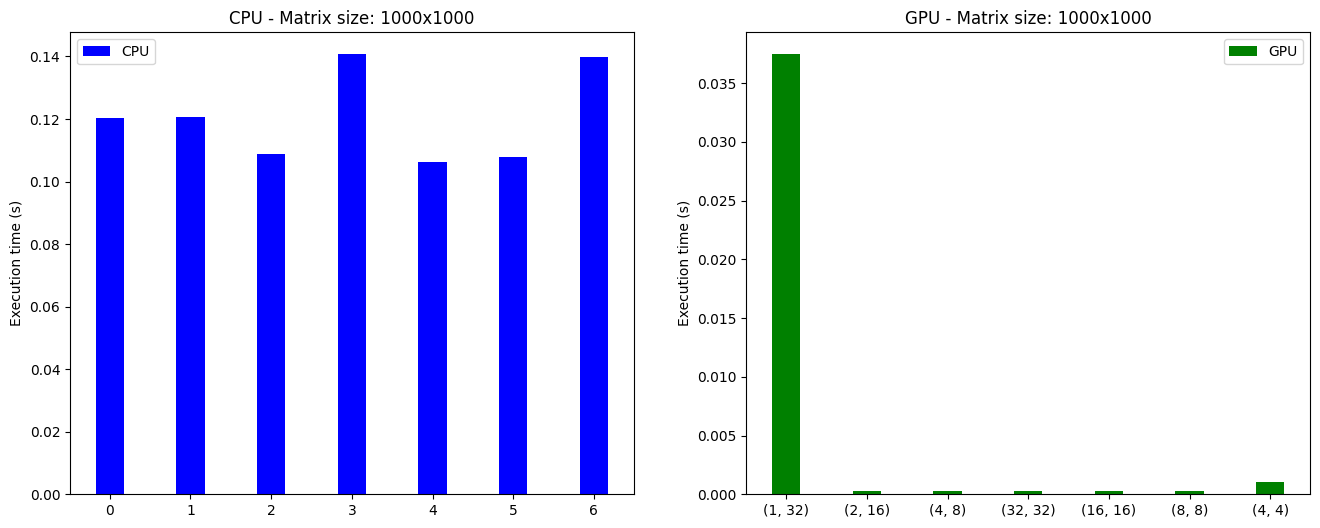

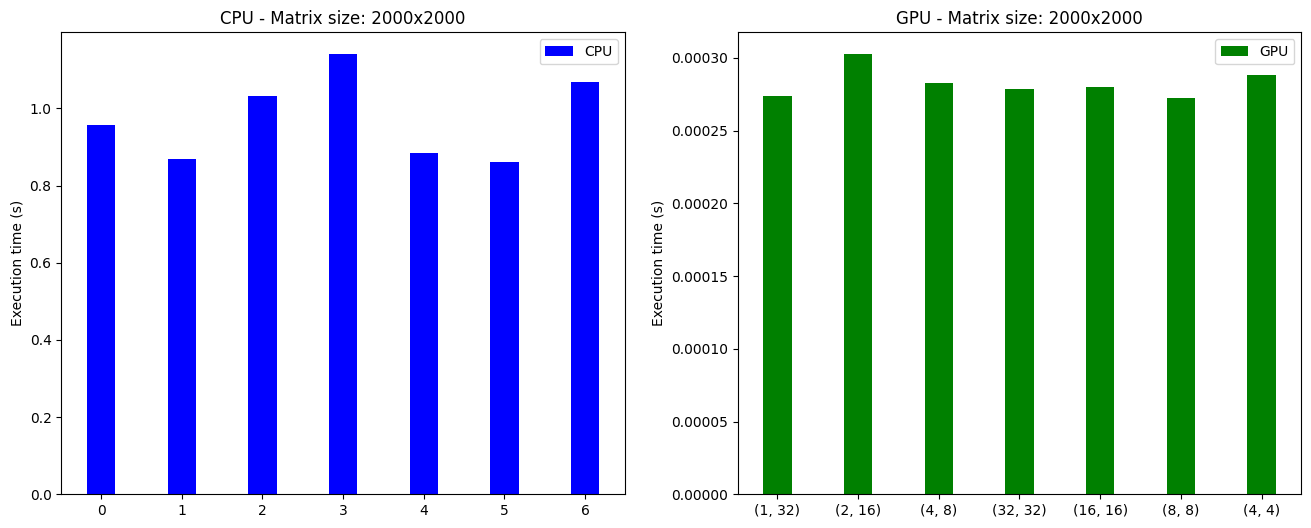

In [5]:
### BEGIN SOLUTION
import numpy as np
from numba import cuda
import time
import matplotlib.pyplot as plt

# The cuda kernel
@cuda.jit
def reconstruct_svd(U, s, Vt, A):
    row, col = cuda.grid(2)
    if row < U.shape[0] and col < Vt.shape[1]:
        value = 0
        for i in range(s.shape[0]):
            value += s[i] * U[row, i] * Vt[i, col]
        A[row, col] = value

def run_experiment(N, block_size):
    # Create the matrices
    A = np.random.rand(N, N)
    U, s, Vt = np.linalg.svd(A, full_matrices=True)

    # Measure the reconstruction on the CPU
    start_cpu = time.time()
    A_reconstructed_cpu = np.dot(U, np.dot(np.diag(s), Vt))
    end_cpu = time.time()
    cpu_time = end_cpu - start_cpu

    # Allocate memory on the GPU
    U_device = cuda.to_device(U)
    s_device = cuda.to_device(s)
    Vt_device = cuda.to_device(Vt)
    A_device = cuda.to_device(A)

    # Invoking a cuda kernel
    num_blocks_x = A.shape[0] // block_size[0]
    if N % num_blocks_x:
      num_blocks_x += 1
    num_blocks_y = A.shape[1] // block_size[1]
    if N % num_blocks_y:
      num_blocks_y += 1
    num_blocks = (num_blocks_x, num_blocks_y)

    # Run the kernel and measure the execution time
    start_gpu = time.time()
    reconstruct_svd[num_blocks, block_size](U_device, s_device, Vt_device, A_device)
    end_gpu = time.time()
    gpu_time = end_gpu - start_gpu

    return cpu_time, gpu_time

# Configurations and experiments
matrix_sizes = [1000, 2000]
block_sizes = [(1, 32), (2, 16), (4, 8), (32, 32), (16, 16), (8, 8), (4, 4)]
num_runs = 5
results = {}
for N in matrix_sizes:
    for block_size in block_sizes:
        cpu_times = []
        gpu_times = []
        for _ in range(num_runs):
            cpu_time, gpu_time = run_experiment(N, block_size)
            cpu_times.append(cpu_time)
            gpu_times.append(gpu_time)
        results[(N, block_size, 'cpu')] = np.mean(cpu_times)
        results[(N, block_size, 'gpu')] = np.mean(gpu_times)
        print("Finished runs for matrix size: {}, block size: {}".format(
            N, block_size
        ))


# Displaying the results
for N in matrix_sizes:
    cpu_times = [results[(N, block_size, 'cpu')] for block_size in block_sizes]
    gpu_times = [results[(N, block_size, 'gpu')] for block_size in block_sizes]

    bar_width = 0.35
    block_configs = np.arange(len(block_sizes))
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].bar(block_configs, cpu_times, bar_width, label='CPU', color='blue')
    axs[0].set_title(f'CPU - Matrix size: {N}x{N}')
    axs[0].set_ylabel('Execution time (s)')
    axs[0].set_xticks(block_configs)
    # axs[0].set_xticklabels([str(block_size) for block_size in block_sizes])
    axs[0].legend()
    
    axs[1].bar(block_configs, gpu_times, bar_width, label='GPU', color='green')
    axs[1].set_title(f'GPU - Matrix size: {N}x{N}')
    axs[1].set_ylabel('Execution time (s)')
    axs[1].set_xticks(block_configs)
    axs[1].set_xticklabels([str(block_size) for block_size in block_sizes])
    axs[1].legend()

    plt.show()

### END SOLUTION

Führe 2-3 Experimente mit unterschiedlichen Blockkonfigurationen und Grösse der Input-Daten durch.  
Erstelle dafür ein neues Datenset mit beliebig grossen Matrizen, da die GPU besonders geeignet ist um grosse Inputs zu verarbeiten (Verwende diese untschiedlich grossen Matrizen für alle nachfolgenden Vergeliche und Tasks ebenfalls).  
Messe die Performance des GPU-Kernels mittels geeigneten Funktionen.  
Welche Blockgrösse in Abhängigkeit mit der Input-Grösse hat sich bei dir basierend auf deinen Experimenten als am erfolgreichsten erwiesen?  
Welches sind deiner Meinung nach die Gründe dafür?  
Wie sind die Performance Unterschiede zwischen deiner CPU und GPU Implementierung? Diskutiere deine Analyse (ggf. mit Grafiken).

<font color='blue'>
Wir erstellen Matrizen der Grösse 1000 X 1000 und 2000 X 2000 sowie Blockkonfigurationen mit (1, 32), (2, 16), (4, 8), (32, 32), (16, 16), (8, 8), (4, 4). Wir sehen für die GPU, dass sich eine grössere Input-Grösse als effizienter erweist. Mit einer 2000 X 2000 Matrix sind wir ungefähr 14 mal schneller als mit einer 1000 X 1000. Die Laufzeit mit verschiedenen Threads pro Block unterscheidet sich jetzt bei der grösseren Matrix nicht beträchtlich. Was bei der kleineren der Fall zu sein scheint, vielleicht auf Grund der Kompilierzeit für den ersten Aufruf des Kernels. Die GPU ist effizienter mit grösseren Input-Daten, weil wir die Resourcen der GPU besser ausnutzen, sprich die Anzahl der Threads und Blöcke besser verteilen.
Die Performance unterschiede zwischen der CPU und GPU sind beträchtlich. Für die kleinere Matrix sind wir um ein 100-faches schneller und für die grössere um ein 4000-faches.

##### 5.2.2 Shared Memory auf der GPU
Optimiere deine Implementierung von oben indem du das shared Memory der GPU verwendest. Führe wieder mehrere Experimente mit unterschiedlicher Datengrösse durch und evaluiere den Speedup gegenüber der CPU Implementierung.

Links:
* [Best Practices Memory Optimizations](https://docs.nvidia.com/cuda/cuda-c-best-practices-guide/index.html#memory-optimizations)
* [Examples: Matrix Multiplikation und Shared Memory](https://numba.readthedocs.io/en/latest/cuda/examples.html)

/usr/local/lib/python3.10/dist-packages/numba/cuda/dispatcher.py:488: NumbaPerformanceWarning: Grid size 64 will likely result in GPU under-utilization due to low occupancy.
  warn(NumbaPerformanceWarning(msg))


Finished runs for matrix size: 128, block size: (16, 16)
Finished runs for matrix size: 256, block size: (16, 16)
Finished runs for matrix size: 512, block size: (16, 16)
Finished runs for matrix size: 1024, block size: (16, 16)
Finished runs for matrix size: 2048, block size: (16, 16)


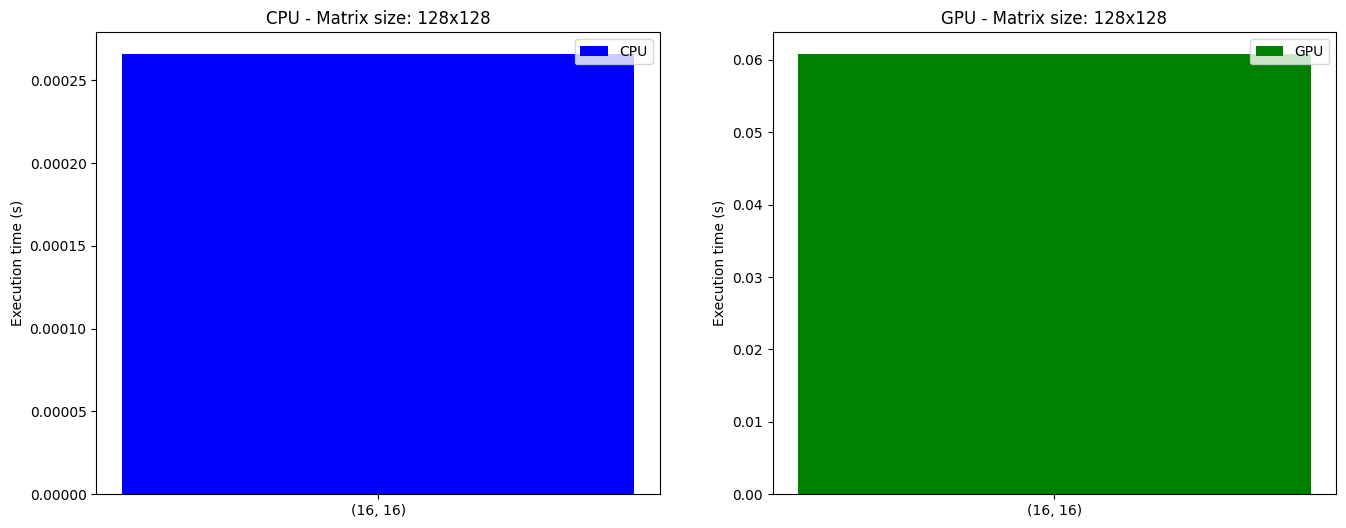

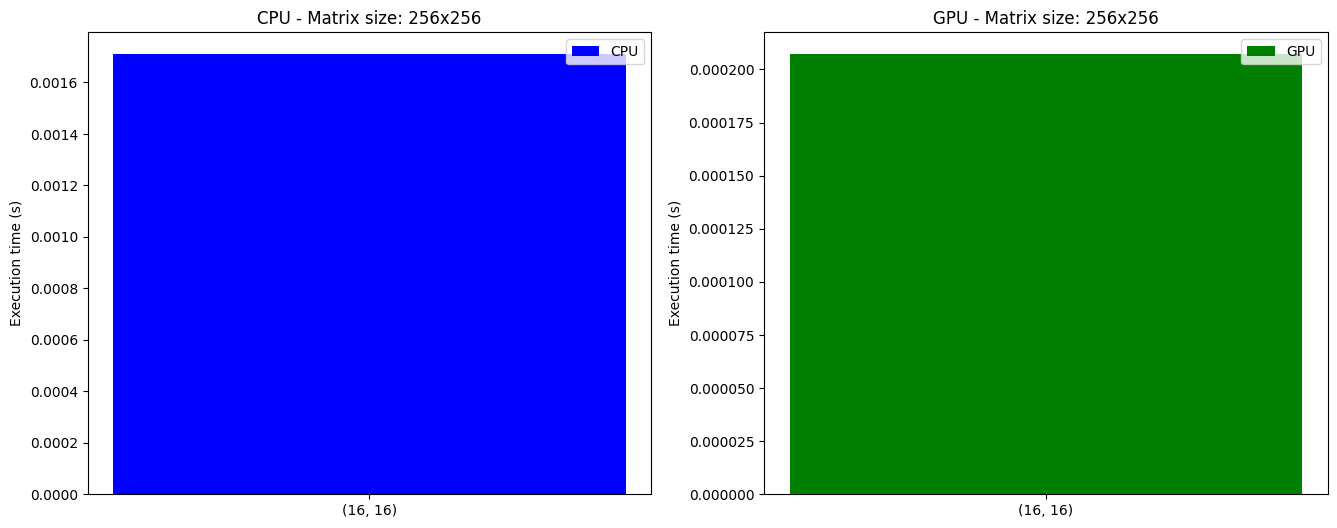

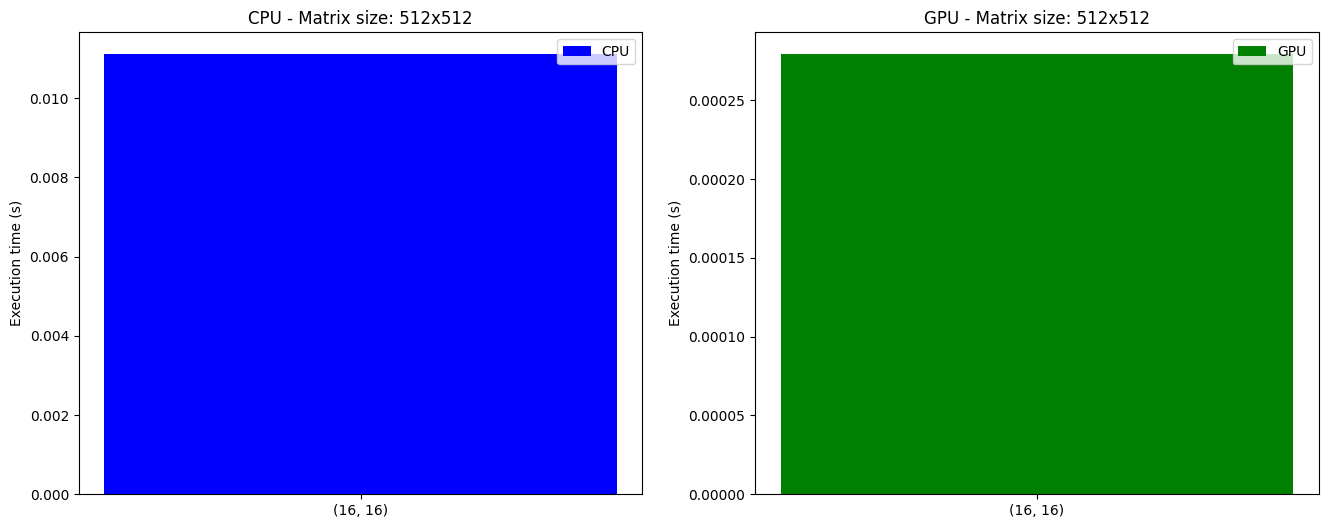

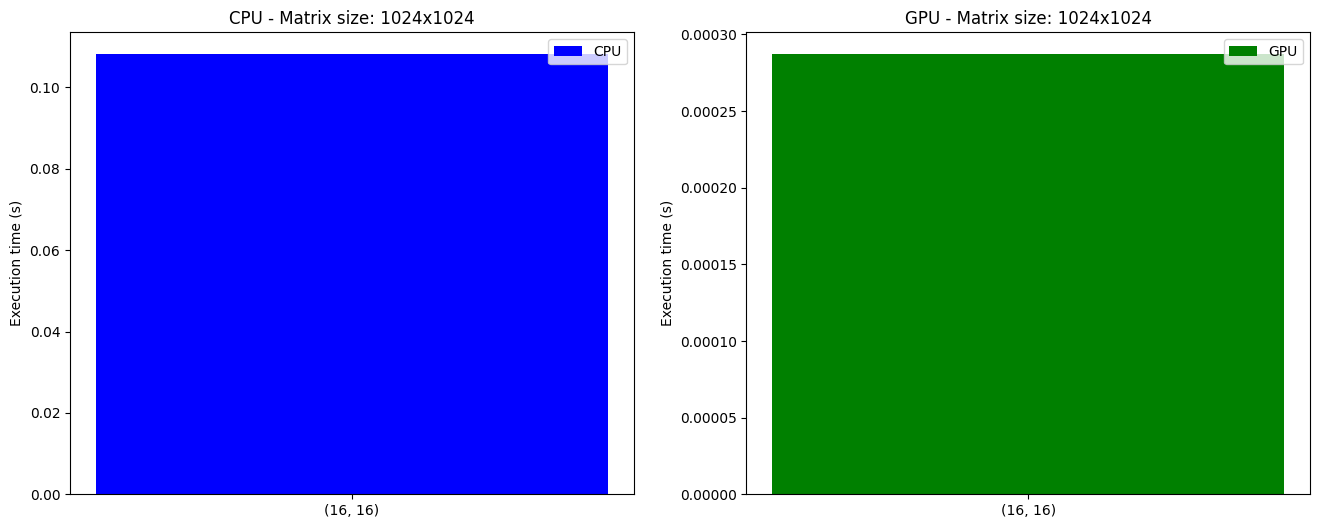

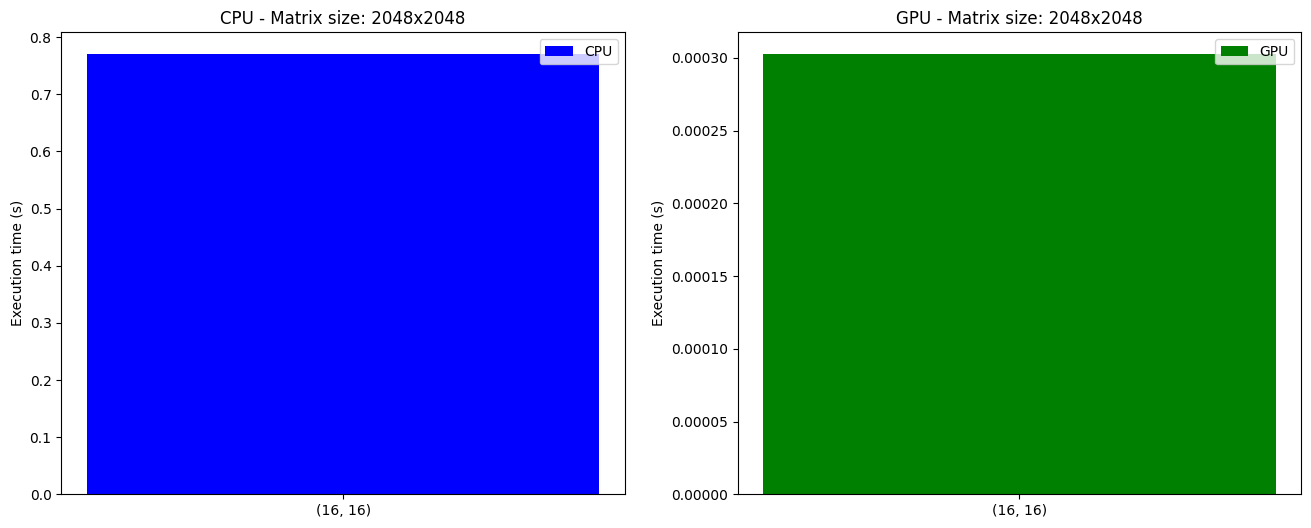

In [ ]:
import numpy as np
import numba
from numba import cuda
import time
import matplotlib.pyplot as plt
from math import ceil


@cuda.jit
def reconstruct_svd_shared_memory(U, s, Vt, A):
    TPB = 16
    # Define arrays in the shared memory
    sU = cuda.shared.array(shape=(TPB, TPB), dtype=numba.float32)
    ss = cuda.shared.array(shape=(TPB,), dtype=numba.float32)
    sVt = cuda.shared.array(shape=(TPB, TPB), dtype=numba.float32)

    x, y = cuda.grid(2)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    bpg = cuda.gridDim.x    # blocks per grid

    # Each thread computes one element in the result matrix.
    tmp = numba.float32(0.)
    for i in range(bpg):
        # Preload data into shared memory
        sU[ty, tx] = 0
        ss[tx] = 0
        sVt[ty, tx] = 0
        if y < U.shape[0] and (tx + i * TPB) < U.shape[1]:
            sU[ty, tx] = U[y, tx + i * TPB]
        if (tx + i * TPB) < s.shape[0]:
            ss[tx] = s[tx + i * TPB]
        if (ty + i * TPB) < Vt.shape[0] and x < Vt.shape[1]:
            sVt[ty, tx] = Vt[ty + i * TPB, x]

        # Wait until all threads finish preloading
        cuda.syncthreads()

        # Compute partial product on the shared memory
        for j in range(TPB):
            tmp += sU[ty, j] * ss[j] * sVt[j, tx]

        # Wait until all threads finish computing
        cuda.syncthreads()

    if y < A.shape[0] and x < A.shape[1]:
        A[y, x] = tmp


def run_experiment(N, block_size):
    # Create the matrices on the host
    A = np.random.rand(N, N)
    U, s, Vt = np.linalg.svd(A, full_matrices=True)

    # Measure the reconstruction on the CPU
    start_cpu = time.time()
    A_cpu = np.dot(U, np.dot(np.diag(s), Vt))
    end_cpu = time.time()
    cpu_time = end_cpu - start_cpu

    # Allocate memory on the GPU
    U_device = cuda.to_device(U)
    s_device = cuda.to_device(s)
    Vt_device = cuda.to_device(Vt)
    A_device = cuda.to_device(A)

    # Invoking a cuda kernel
    block_size_x = ceil(A.shape[0] / block_size[0])
    if N % block_size_x:
      block_size_x += 1
    block_size_y = ceil(A.shape[1] / block_size[1])
    if N % block_size_y:
      block_size_y += 1
    num_blocks = (block_size_x, block_size_y)

    # Run the kernel and measure the execution time
    start_gpu = time.time()
    reconstruct_svd_shared_memory[num_blocks, block_size](
        U_device, s_device, Vt_device, A_device
    )
    end_gpu = time.time()
    gpu_time = end_gpu - start_gpu

    # Transfer result back to CPU
    A_gpu = A_device.copy_to_host()

    return cpu_time, gpu_time

# Configurations and experiments
matrix_sizes = [128, 256, 512, 1024, 2048]
block_sizes = [(16, 16)]
num_runs = 5
results = {}
for N in matrix_sizes:
    for block_size in block_sizes:
        cpu_times = []
        gpu_times = []
        for _ in range(num_runs):
          cpu_time, gpu_time = run_experiment(N, block_size)
          cpu_times.append(cpu_time)
          gpu_times.append(gpu_time)
        results[(N, block_size, 'cpu')] = np.mean(cpu_times)
        results[(N, block_size, 'gpu')] = np.mean(gpu_times)
        print("Finished runs for matrix size: {}, block size: {}".format(
            N, block_size
        ))

# Display the results
for N in matrix_sizes:
    cpu_times = [results[(N, block_size, 'cpu')] for block_size in block_sizes]
    gpu_times = [results[(N, block_size, 'gpu')] for block_size in block_sizes]

    bar_width = 0.35
    block_configs = np.arange(len(block_sizes))
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))
    
    axs[0].bar(block_configs, cpu_times, bar_width, label='CPU', color='blue')
    axs[0].set_title(f'CPU - Matrix size: {N}x{N}')
    axs[0].set_ylabel('Execution time (s)')
    axs[0].set_xticks(block_configs)
    axs[0].set_xticklabels([str(block_size) for block_size in block_sizes])
    axs[0].legend()
    
    axs[1].bar(block_configs, gpu_times, bar_width, label='GPU', color='green')
    axs[1].set_title(f'GPU - Matrix size: {N}x{N}')
    axs[1].set_ylabel('Execution time (s)')
    axs[1].set_xticks(block_configs)
    axs[1].set_xticklabels([str(block_size) for block_size in block_sizes])
    axs[1].legend()
    
    plt.show()


Was sind deine Erkenntnisse bzgl. GPU-Memory-Allokation und des Daten-Transferes auf die GPU? Interpretiere deine Resultate.

<font color='blue'>Die GPU verfügt über einen eigenen Speicher, der von der CPU getrennt ist. Wenn wir Berechnungen auf der GPU durchführen möchten, müssen wir die Daten von der CPU zur GPU übertragen. Dieser Vorgang ist mit einem erheblichen Overhead verbunden und kann manchmal sogar die gesamte Berechnungszeit dominieren, insbesondere bei kleineren Datenmengen oder häufigen Datenübertragungen.
<br />
Innerhalb der GPU selbst gibt es verschiedene Arten von Speicher: Global, Shared, Constant und Texture Memory. Jeder davon hat seine eigenen Anwendungsfälle. Der Shared Memory beispielsweise ist eine kleiner Speicher, der von allen Threads in einem Block gemeinsam genutzt wird. Er hat schnellere Zugriffszeiten als der Global Memory und ermöglicht den Threads schnellere Zugriffszeiten.
<br />
In Bezug auf die Übertragung der Daten kann deren Minimierung zwischen Host (CPU) und Device (GPU), die Leistung von GPU genutzten Anwendungen erheblich verbessern. Eine Leistungssteigerung kann erreicht werden, indem so viele Berechnungen wie möglich auf der GPU durchgeführt werden und gleichzeitig der Bedarf an Datenübertragung reduziert wird. Techniken wie "Zero-Copy" oder "Pinned" Speicher können ebenfalls eingesetzt werden, um die Datenübertragung zwischen CPU und GPU zu verbessern.
<br />
Eine Erkenntnisse aus den Experimenten ist, dass die GPU bei größeren Matrizengrößen deutlich schneller rechnet als die CPU. Dies ist zu erwarten und entspricht den Stärken der GPU. GPUs zeichnen sich durch die Verarbeitung großer, parallelisierbarer Datensätze und Berechnungen aus. Ihre Architektur mit tausenden von Kernen ermöglicht die Verarbeitung vieler Elemente gleichzeitig. Dies führt zu einer beträchtlichen Beschleunigung bei größeren Datenmengen.
<br />
Bei kleineren Datenmengen können jedoch die Kosten für die Datenübertragung und die Zuweisung von GPU Speicher die Vorteile der parallelen Ausführung überwiegen, so dass die CPU schneller arbeitet als die GPU. Diese Tatsache unterstreicht, wie wichtig es ist, die Problemgröße zu verstehen, wenn man sich für eine CPU- oder GPU-Implementierung entscheidet.</font>

##### 5.2.3 Bonus: Weitere Optimierungen
Optimiere deine Implementation von oben weiter. Damit du Erfolg hast, muss der Data-Reuse noch grösser sein.

In [ ]:
### BEGIN SOLUTION
### END SOLUTION

#### 5.3 NVIDIA Profiler

Benutze einen Performance Profiler von NVIDIA, um Bottlenecks in deinem Code zu identifizieren bzw. unterschiedliche Implementierungen (Blocks, Memory etc.) zu vergleichen. 

* Siehe Beispiel example_profiling_CUDA.ipynb
* [Nsight](https://developer.nvidia.com/nsight-visual-studio-edition) für das Profiling des Codes und die Inspektion der Ergebnisse (neuste Variante)
* [nvprof](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#nvprof-overview)
* [Nvidia Visual Profiler](https://docs.nvidia.com/cuda/profiler-users-guide/index.html#visual)

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
!nvprof python drive/MyDrive/gpu.py

==8858== NVPROF is profiling process 8858, command: python3 drive/MyDrive/gpu.py
Finished runs for matrix size: 1024, block size: (16, 16)
Finished runs for matrix size: 2048, block size: (16, 16)
==8858== Profiling application: python3 drive/MyDrive/gpu.py
==8858== Warning: 1 records have invalid timestamps due to insufficient device buffer space. You can configure the buffer space using the option --device-buffer-size.
==8858== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   93.37%  2.35880s         9  262.09ms  77.965ms  486.53ms  _ZN6cudapy8__main__15reconstruct_svdB2v1B106cw51cXTLSUwHBinCqbbgUAAGBlq82ILSCEQYkgSQBFCjFSaBZJtttTo4sahbKRjoKKiDvAVKN0AuNEDVYWGDJATUC_2bQZ12oCAA_3d_3dE5ArrayIdLi2E1C7mutable7alignedE5ArrayIdLi1E1C7mutable7alignedE5ArrayIdLi2E1C7mutable7alignedE5ArrayIdLi2E1C7mutable7alignedE
                    6.63%  167.55ms        40  4.1888ms  1.9830us  16.617ms  [CUDA memcpy HtoD]
      API calls: 

In [15]:
!nvprof python drive/MyDrive/gpu_shared_memory.py

==9077== NVPROF is profiling process 9077, command: python3 drive/MyDrive/gpu_shared_memory.py
Finished runs for matrix size: 1024, block size: (16, 16)
Finished runs for matrix size: 2048, block size: (16, 16)
==9077== Profiling application: python3 drive/MyDrive/gpu_shared_memory.py
==9077== Profiling result:
            Type  Time(%)      Time     Calls       Avg       Min       Max  Name
 GPU activities:   72.23%  526.80ms        10  52.680ms  11.831ms  93.736ms  _ZN6cudapy8__main__29reconstruct_svd_shared_memoryB2v1B106cw51cXTLSUwHBinCqbbgUAAGBlq82ILSCEQYkgSQBFCjFSaBZJtttTo4sahbKRjoKKiDvAVKN0AuNEDVYWGDJATUC_2bQZ12oCAA_3d_3dE5ArrayIdLi2E1C7mutable7alignedE5ArrayIdLi1E1C7mutable7alignedE5ArrayIdLi2E1C7mutable7alignedE5ArrayIdLi2E1C7mutable7alignedE
                   27.77%  202.58ms        40  5.0645ms  1.9840us  22.647ms  [CUDA memcpy HtoD]
      API calls:   33.13%  228.57ms        33  6.9263ms  5.6910us  93.357ms  cuMemFree
                   32.57%  224.69ms        40  5.6173ms

> Du kannst NVIDIA Nsights Systems und den Nvidia Visual Profiler auf deinem PC installieren und die Leistungsergebnisse aus einer Remote-Instanz visualisieren, auch wenn du keine GPU an/in deinem PC hast. Dafür kannst du die ``*.qdrep`` Datei generieren und danach lokal laden.


Dokumentiere deine Analyse ggf. mit 1-2 Visualisierungen und beschreibe, welche Bottlenecks du gefunden bzw. entschärft hast.

<font color='blue'>Leider wird der Nvidia Visual Profiler auf Mac nicht mehr unterstützt, weswegen wir uns in der Analyse ausschliesslich auf den Output von nvprof stützen. Wir sehen für die Matrizen Grössen von 1024 und 2048 und für die Block Grössen (16, 16), dass die meiste Zeit der GPU Aktivität für die Ausführung des Kernel in Anspruch genommen wurde. Auf dem zweitem Platz kommt dann das kopieren des Speichers vom Host zu Device. Durch das Konzept der Shared Memory konnte einiges an Ausführungszeit eingespart werden, in diesem spezifischen Fall sprechen wir von einem Faktor von 5.</font>

### 6 Beschleunigte Rekonstruktion mehrerer Bilder
#### 6.1 Implementierung
Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import math
# Define the GPU kernel for reconstruction
@cuda.jit
def reconstruct_svd(U, s, Vt, A):
    row, col = cuda.grid(2)
    if row < U.shape[0] and col < Vt.shape[1]:
        value = 0
        for i in range(s.shape[0]):
            value += s[i] * U[row, i] * Vt[i, col]
        A[row, col] = value

# Create the matrices on the host
n_matrix_size = 1000
n_image = 36
A = np.random.rand(n_image, N, N)
U, s, Vt = np.linalg.svd(A)

# Specify the number of blocks and threads
threadsperblock = (16, 16)
blockspergrid_x = A.shape[1] // threadsperblock[0]
if blockspergrid_x % n_matrix_size:
  blockspergrid_x += 1
blockspergrid_y = A.shape[2] // threadsperblock[1]
if blockspergrid_y % n_matrix_size:
  blockspergrid_y += 1
blockspergrid = (blockspergrid_x, blockspergrid_y)

# Create CUDA streams for each image
streams = [cuda.stream() for _ in range(n_image)]

# Launch the kernel for each image in its own stream
for i in range(n_image):
    with streams[i].auto_synchronize():
        U_device = cuda.to_device(U[i], stream=streams[i])
        s_device = cuda.to_device(s[i], stream=streams[i])
        Vt_device = cuda.to_device(Vt[i], stream=streams[i])
        A_device = cuda.device_array_like(U[i], stream=streams[i])
        reconstruct_svd[blockspergrid, threadsperblock, streams[i]](U_device, s_device, Vt_device, A_device)



Verwende einige der in bisher gelernten Konzepte, um mehrere Bilder gleichzeitig parallel zu rekonstruieren. Weshalb hast du welche Konzepte für deine Implementierung verwenden? Versuche die GPU konstant auszulasten und so auch die verschiedenen Engines der GPU parallel zu brauchen. Untersuche dies auch für grössere Inputs als die MRI-Bilder.

<font color='blue'>
Um mehrere Bilder gleichzeitig zu verarbeiten, können wir Konzepte des parallelen Rechnens nutzen.
<br/>
CUDA Threads und Blöcke: In CUDA sind die grundlegenden Ausführungseinheiten Threads. Threads werden in Blöcken gruppiert, und Blöcke werden in einem Raster (Grid) gruppiert. Wir können jedes Bild einem separaten Thread oder Block zuordnen, abhängig von der Anzahl der Bilder und ihrer Größe. Dadurch können wir Operationen auf mehreren Bildern gleichzeitig durchführen.
<br/>
In der obigen Implementierung haben wir je Bild einen separaten CUDA Stream erstellt. Wenn wir nun den Kernel ausführen, übergeben wir als drittes Argument den jeweiligen Stream. Auto_synchronize() wird genutzt um sicherzustellen, dass am Ende des 'with'-Blocks alle Operationen automatisch synchronisiert wurden, bevor wir fortfahren. </font>

#### 6.2 Analyse
Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

In [ ]:
import math
from numba import cuda
import numpy as np
import time

@cuda.jit
def reconstruct_svd(U, s, Vt, A):
    row, col = cuda.grid(2)
    if row < U.shape[0] and col < Vt.shape[1]:
        value = 0
        for i in range(s.shape[0]):
            value += s[i] * U[row, i] * Vt[i, col]
        A[row, col] = value

def run_parallel(n_image, n_matrix_size):
    # Create the matrices on the host
    A = np.random.rand(n_image, n_matrix_size, n_matrix_size)
    U, s, Vt = np.linalg.svd(A)

    # Specify the number of blocks and threads
    threadsperblock = (16, 16)
    blockspergrid_x = A.shape[1] // threadsperblock[0]
    if blockspergrid_x % n_matrix_size:
      blockspergrid_x += 1
    blockspergrid_y = A.shape[2] // threadsperblock[1]
    if blockspergrid_y % n_matrix_size:
      blockspergrid_y += 1
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Create CUDA streams for each image
    streams = [cuda.stream() for _ in range(n_image)]

    start = time.time()
    # Launch the kernel for each image in its own stream
    for i in range(n_image):
        with streams[i].auto_synchronize():
            U_device = cuda.to_device(U[i], stream=streams[i])
            s_device = cuda.to_device(s[i], stream=streams[i])
            Vt_device = cuda.to_device(Vt[i], stream=streams[i])
            A_device = cuda.device_array_like(U[i], stream=streams[i])
            reconstruct_svd[blockspergrid, threadsperblock, streams[i]](U_device, s_device, Vt_device, A_device)
    end = time.time()

    return end - start

# Configuration for experiments
n_images = [5, 50, 100, 200, 300, 400]
n_matrix_sizes = [500]
results_parallel = {}
for n_matrix in n_matrix_sizes:
  for n_image in n_images:
    gpu_time = run_parallel(n_image, n_matrix)
    results_parallel[(n_matrix, n_image, "parallel")] = gpu_time
    print("Finished run for matrix size: {}, image size: {}".format(
        n_matrix, n_image
    ))

print(results)

Finished run for matrix size: 500, image size: 5
Finished run for matrix size: 500, image size: 50
Finished run for matrix size: 500, image size: 100
Finished run for matrix size: 500, image size: 200
Finished run for matrix size: 500, image size: 300
Finished run for matrix size: 500, image size: 400
{(500, 5, 'sequential'): 0.24394774436950684, (500, 50, 'sequential'): 3.349916458129883, (5, 500, 'parallel'): 0.21502351760864258, (50, 500, 'parallel'): 0.20249080657958984, (100, 500, 'parallel'): 0.5039284229278564, (500, 5, 'parallel'): 0.8686835765838623, (500, 50, 'parallel'): 0.2106766700744629, (500, 100, 'parallel'): 0.38556647300720215}


In [ ]:
import math
from numba import cuda
import numpy as np

# Define the GPU kernel for reconstruction
@cuda.jit
def reconstruct_svd(U, s, Vt, A):
    row, col = cuda.grid(2)
    if row < U.shape[0] and col < Vt.shape[1]:
        value = 0
        for i in range(s.shape[0]):
            value += s[i] * U[row, i] * Vt[i, col]
        A[row, col] = value

def run_sequential(n_images, n_matrix_size):
    # Create the matrices on the host
    A = np.random.rand(n_images, n_matrix_size, n_matrix_size)
    U, s, Vt = np.linalg.svd(A)

    # Number of blocks in the grid
    threadsperblock = (16, 16)
    blockspergrid_x = A.shape[1] // threadsperblock[0]
    if blockspergrid_x % n_matrix_size:
      blockspergrid_x += 1
    blockspergrid_y = A.shape[2] // threadsperblock[1]
    if blockspergrid_y % n_matrix_size:
      blockspergrid_y += 1
    blockspergrid = (blockspergrid_x, blockspergrid_y)

    # Run the kernel and measure the execution time
    start = time.time()
    for i in range(n_images):
        U_device = cuda.to_device(U)
        s_device = cuda.to_device(s)
        Vt_device = cuda.to_device(Vt)
        A_device = cuda.device_array_like(U)
        reconstruct_svd[blockspergrid, threadsperblock](U_device[i], s_device[i], Vt_device[i], A_device[i])
    end = time.time()

    return end - start

# Configuration for experiments
n_images = [5, 50, 100, 200, 300, 400]
n_matrix_sizes = [500]
results_sequential = {}
for n_matrix in n_matrix_sizes:
  for n_image in n_images:
    gpu_time = run_sequential(n_image, n_matrix)
    results_sequential[(n_matrix, n_image, "sequential")] = gpu_time
    print("Finished run for matrix size: {}, image size: {}".format(
        n_matrix, n_image
    ))

print(results_sequential)


Finished run for matrix size: 500, image size: 5
Finished run for matrix size: 500, image size: 50
Finished run for matrix size: 500, image size: 100
Finished run for matrix size: 500, image size: 200
Finished run for matrix size: 500, image size: 300
Finished run for matrix size: 500, image size: 400
{(500, 5, 'sequential'): 0.25250983238220215, (500, 50, 'sequential'): 2.757535219192505, (500, 100, 'sequential'): 10.229215621948242, (500, 200, 'sequential'): 40.39109754562378, (500, 300, 'sequential'): 90.53093457221985, (500, 400, 'sequential'): 160.63082265853882}


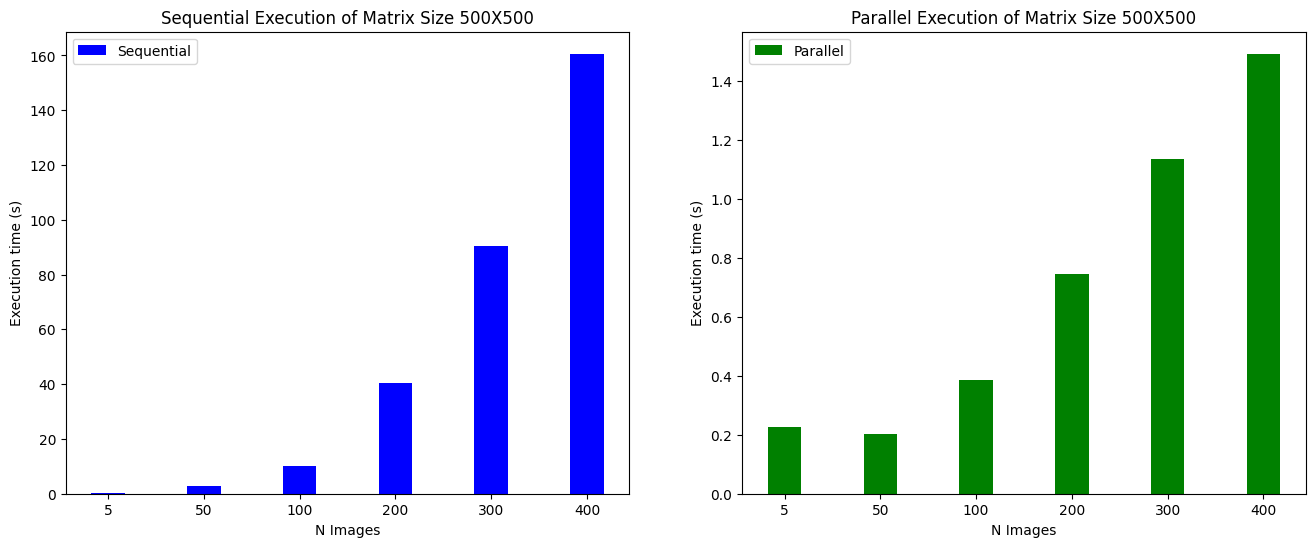

In [ ]:
import matplotlib.pyplot as plt
for N in n_matrix_sizes:
    sequential_times = [results_sequential[(N, n_image, 'sequential')] for n_image in n_images]
    parallel_times = [results_parallel[(N, n_image, 'parallel')] for n_image in n_images]

    bar_width = 0.35
    block_configs = np.arange(len(n_images))
    fig, axs = plt.subplots(1, 2, figsize=(16, 6))

    axs[0].bar(block_configs, sequential_times, bar_width, label='Sequential', color='blue')
    axs[0].set_title(f'Sequential Execution of Matrix Size {N}X{N}')
    axs[0].set_ylabel('Execution time (s)')
    axs[0].set_xlabel("N Images")
    axs[0].set_xticks(block_configs)
    axs[0].set_xticklabels([str(n_image) for n_image in n_images])
    axs[0].legend()

    axs[1].bar(block_configs, parallel_times, bar_width, label='Parallel', color='green')
    axs[1].set_title(f'Parallel Execution of Matrix Size {N}X{N}')
    axs[1].set_ylabel('Execution time (s)')
    axs[1].set_xlabel("N Images")
    axs[1].set_xticks(block_configs)
    axs[1].set_xticklabels([str(n_image) for n_image in n_images])
    axs[1].legend()

    plt.show()

Vergleiche den Speedup für deine parallele Implementierung im Vergleich zur seriellen Rekonstruktion einzelner Bilder. Analysiere und diskutiere in diesem Zusammenhang die Gesetze von Amdahl und Gustafson.

<font color='blue'>
Wir wählen Matrizen der Grösse (500 X 500) und definieren verschiedene Anzahl an Bildern, z.B. 5, 50 etc. Für die parallel Ausführung sehen wir, dass bei höherer Anzahl die Ausführungszeit nur minimal steigt. Bei der sequentiellen Ausführung ist die Ausführungszeit um einiges grösser. Wir sprechen hier von einem Faktor von 100.
<br/>
Nach dem Amdahlschen Gesetz ist die Gesamtbeschleunigung durch den Anteil der Berechnung begrenzt, der nicht parallelisiert werden kann (der sequentielle Teil). Diese Begrenzung wird oft als Amdahls Engpass bezeichnet. Wenn die Anzahl der Bilder jedoch groß ist, macht der parallelisierbare Teil den größten Teil der gesamten Berechnung aus, so dass der Geschwindigkeitszuwachs erheblich ist.
<br/>
Das Gustafson'sche Gesetz besagt, dass mit zunehmender Problemgröße (in diesem Fall eine größere Anzahl von Bildern) mehr parallele Ressourcen (mehr GPU-Kerne) effektiv genutzt werden können. Infolgedessen können wir einen Geschwindigkeitszuwachs erzielen, da der Anteil der Berechnung, der parallelisiert werden kann, mit der Problemgröße steigt. Dies steht im Einklang mit der Beobachtung, dass die parallele Implementierung bei größeren Bildmengen wesentlich schneller ist.
<br/>
Diese Gesetze helfen uns zu verstehen, dass GPUs zwar Berechnungen erheblich beschleunigen können, der Grad der Beschleunigung jedoch sowohl von der Problemgröße als auch vom Anteil der Aufgabe abhängt, der parallelisiert werden kann. In unserem Fall ist die Bildrekonstruktion hochgradig parallelisierbar und profitiert in hohem Masse von der GPU-Architektur, vor allem, wenn es um eine größere Anzahl von Bildern geht. Man beachte jedoch, dass einige Teile unseres Programms (z.B. die Datenübertragung zwischen CPU und GPU) sequentiell bleiben und die Gesamtbeschleunigung begrenzen können.
</font>

#### 6.3 Komponentendiagramm

Erstelle das Komponentendiagramm dieser Mini-Challenge für die Rekunstruktion mehrere Bilder mit einer GPU-Implementierung. Erläutere das Komponentendigramm in 3-4 Sätzen.


<font color='blue'>
Wir definieren mehrere Streams denen wir die einzelnen Bilder mitgeben. Jeder Stream führt drei Prozesse parallel durch: H2D (Host to Device), KE (Kernel Execution) und D2H (Device 2 Host). Unsere Funktion reconstruct_svd() erhält einen Decorator welche den CUDA Kernel kompiliert und ausführt. Um den CUDA Kernel auszuführen müssen der Funktion die Anzahl Blöcke pro Grid und die Anzahl Threads pro Block mitgegeben werden.
</font>
<br/>
<img src="images/Component Diagram.png" alt="Test">

### 7 Reflexion

Reflektiere die folgenden Themen indem du in 3-5 Sätzen begründest und anhand von Beispielen erklärst.

1: Was sind deiner Meinung nach die 3 wichtigsten Prinzipien bei der Beschleunigung von Code?

<font color='blue'>1. **Parallelität:** Einer der wichtigsten Grundsätze bei der Beschleunigung von Code mit der GPU ist die Parallelisierung der Daten. GPUs sind darauf ausgelegt, mehrere Operationen gleichzeitig durchzuführen. Bei unserer Aufgabe der Bildrekonstruktion konnten wir beispielsweise diese für mehrere Bilder gleichzeitig durchführen und dabei die parallele Verarbeitung der GPU nutzen.
<br/>
2. **Speichermanagement:** Ein weiterer kritischer Aspekt ist die effiziente Nutzung des Speichers. Der GPU-Speicher ist im Allgemeinen kleiner und empfindlicher gegenüber Latenzzeiten als der CPU-Speicher. Daher kann die Art und Weise, wie wir Speicher zuweisen und darauf zugreifen, die Geschwindigkeit von GPU Anwendungen erheblich beeinflussen. So haben wir für die Optimierung Shared-Memory verwendet, auf den schneller zugegriffen werden kann als auf den Global-Memory. Bei der richtigen Verwendung können die GPU-Operationen erheblich beschleunigt werden.
<br/>
3. **Allgemein:** Die GPU-Architektur zu verstehen und effektiv zu nutzen ist entscheidend für die Beschleunigung von Code. Dazu gehört der richtige Einsatz von Threads und Blöcken sowie das Bewusstsein für die Warp-Ausführung. In den vorherigen Aufgaben haben wir die Anzahl der Threads pro Block und die Anzahl der Blöcke pro Raster (Grid) festgelegt, um unsere Berechnungen effektiv auf die Architektur der GPU abzubilden. Auf diese Weise konnten wir die Rechenressourcen der GPU optimal nutzen.</font>

2: Welche Rechenarchitekturen der Flynnschen Taxonomie wurden in dieser Mini-Challenge wie verwendet?

<font color='blue'>Bei den durchgeführten Aufgaben wurden zwei Arten von Rechenarchitekturen aus der Taxonomie von Flynn verwendet: Single Instruction Single Data (SISD) und Single Instruction Multiple Data (SIMD).
<br/>
1. **SISD:** Diese Architektur entspricht einer traditionellen CPU-Ausführung, bei der eine einzelne Anweisung auf einzelne Daten durchgeführt wird. Als wir zum Beispiel zum ersten Mal die SVD-Funktion (Singular Value Decomposition) zur Bildrekonstruktion auf der CPU implementierten, verwendeten wir einen sequenziellen Ansatz, also ein SISD Paradigma.
<br/>
2. **SIMD:** Die durchgeführten GPU Operationen sind repräsentativ für das SIMD-Modell. Bei diesem Modell wird eine einzige Anweisung gleichzeitig auf mehreren Streams ausgeführt, z.B. als wir mehrere Bilder gleichzeitig mit der GPU rekonstruierten oder als wir die Implementierung unter Verwendung des gemeinsamen Speichers der GPU optimierten, verwendeten wir das SIMD-Modell. Die GPU war in der Lage, dieselbe Operation an verschiedenen Datenpunkten (Pixeln mehrerer Bilder) gleichzeitig auszuführen, wodurch die Berechnung erheblich beschleunigt wurde.</font>

3: Haben wir es in dieser Mini-Challenge hauptsächlich mit CPU- oder IO-Bound Problemen zu tun? Nenne Beispiele.

<font color='blue'>Bei den Aufgaben dieser Mini Challenge handelt es sich vorwiegend um CPU gebundene Probleme, wohingegen auch IO gebundene Probleme auftauchen können.
<br/>
CPU-gebundene Aufgaben sind solche, die Rechenressourcen erfordern und bei denen die Geschwindigkeit der CPU der begrenzende Faktor ist. In unserem Fall sind die Berechnungen, die wir durchführen, wie z.B. Matrixmanipulationen für die Bildrekonstruktion, recht rechenintensiv. Deswegen nutzen wir den Einsatz eines Grafikprozessors, der für umfangreiche parallele Berechnungen ausgelegt ist und somit die Ausführungszeit dieser Aufgaben erheblich verkürzen kann.
<br/>
IO-gebundene Aufgaben hingegen sind solche, bei denen das System auf die Beendigung von Input/Output-Operationen (wie Festplatten- oder Netzwerkoperationen) wartet. Das Bottleneck der GPU ist das lesen der Daten von der RAM. Darum ist es proportional gesehen, effizienter grössere Matrizen berechnen zu lassen als kleinere.</font>

4: Wie könnte diese Anwendung in einem Producer-Consumer Design konzipiert werden?

<font color='blue'>Bei einem Producer-Consumer-Design erzeugt ein Teil der Anwendung (der Produzent) Daten und ein anderer Teil (der Konsument) verarbeitet oder nutzt diese Daten. 
<br/>
Betrachten wir den Anwendungsfall der Bildzerlegung und Bildrekonstruktion:
<br/>
1. **Produzent:** Der Produzent zerlegt die Bilder mit Hilfe der Singulärwertzerlegung und führt somit eine Bildkomprimierung durch. Danach kann der Producer die komprimierten Bilder einem Broker senden.
<br/>
2. **Konsument:** Der Konsument kann die komprimierten Bilder vom Broker abholen und mit Hilfe der oben aufgeführten Methoden wieder rekonstruieren. In unserem Fall ist der Konsument so konzipiert, dass er die Daten parallel verarbeitet und dabei die Vorteile der GPU nutzen kann.
</font>

5: Was sind die wichtigsten Grundlagen, um mehr Performance auf der GPU in dieser Mini-Challenge zu erreichen?

<font color='blue'>Siehe Punkt 1 da ähnliche Fragestellung.
Weitere Punkte wären:<br/>
**Konfiguration**: Die Wahl der richtigen Konfigurationn für die Blockgrösse ist entscheidend. Die richtige Konfiguration kann die GPU-Auslastung verbessern und den Overhead der Thread-Erstellung und -Verwaltung reduzieren. In den Experimenten haben wir verschiedene Blockgrößen ausprobiert, um diejenige Konfiguration zu finden, mit der die beste Leistung erzielt werden kann.
<br/>
**Berechnung und Datenübertragung**: In Szenarien, in denen sowohl Berechnungs- als auch Datenübertragungsaufgaben anfallen, können Techniken wie CUDA Streams und asynchrone Ausführung verwendet werden, um Ausführungszeiten zu reduzieren.
<br/>
**Speicherzugriff**: Das Ziel der Speicherverwaltung ist es, die Daten effizient vom Global Memory ins jeweilige Shared Memory zu laden, wo von dort auf dem Stream Multiprocessor (SM) die Berechnungen durchgeführt werden können. Der SM führt dann die Instrunktionen auf mehreren Threads aus (SIMD).
<br/>
**Profiling und Optimierung**: Tools wie Nsight und nvprof können wertvolle Einblicke in Leistungsengpässe geben und helfen, Optimierungsmaßnahmen zu definieren. Sie ermöglichen es besser zu verstehen, wie der Code ausgeführt wird und wo es eventuell Verbesserungsmöglichkeiten gibt. Beispielsweise können ineffiziente Speicherzugriffe hervorgehoben werden.
</font>

6: Reflektiere die Mini-Challenge. Was ist gut gelaufen? Wo gab es Probleme? Wo hast du mehr Zeit als geplant gebraucht? Was hast du dabei gelernt? Was hat dich überrascht? Was hättest du zusätzlich lernen wollen? Würdest du gewisse Fragestellungen anders formulieren? Wenn ja, wie?

<font color='blue'>
Die zweite Minichallenge war sehr anspruchsvoll. Zuerst muss man die Theorie verstehen wie die CPU mit der GPU kommuniziert und das ganze Memory Management funktioniert. Wenn man die Theorie einigermassen verstanden hat, muss man ganze noch als Code hinschreiben. Den Code so hinzubekommen, dass er läuft, war für mich die schwierigste Aufgabe. Weil mein Laptop keine CUDA Graphikkarte enthält und sonst auch nicht mit der Theorie der herkömmlichen Computer Architektur übereinstimmt, musste ich auf Google Colab wechseln. Um die Ausführung des Codes besser zu verstehen, nutze ich oft den Debugger in einem IDE. Da das im Google Colab nicht möglich war, hat mir das am Anfang sehr grosse Schwierigkeiten bereitet. Zum Glück wurden genügend Beispiele im Notebook verlinkt für Vektor-Additionen und Matrizen-Multiplikationen auf der GPU, z.B. von CSCS. Die verlinkten Videos haben mir bei der Implementierung sehr geholfen. Bei Fragen zum Theorie- sowie Programmier-Teil konnte ich den Fachexperten jederzeit um Rat fragen. Diese Flexibilität hat es mir ermöglicht, Stück für Stück die Theorie hinter der Mini Challenge besser zu verstehen, wie auch meine Programmier Fähigkeiten auszubauen. Aus meiner Sicht war es genügend Stoff der hier betrachtet wurde und die Implementierung kostet auch sehr viel Zeit, darum würde ich den Umfang beibehalten.
</font>